In [9]:
from matplotlib import pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch_geometric.data import DataLoader

import os
import numpy as np
import pandas as pd

cwd = os.getcwd()
os.chdir('/home/sandbox/workspace/causal_attn')

from models import *
from utils import *
from train import *
from run import instantiate_model
from evaluations import *

os.chdir(cwd)

In [10]:
from torch_geometric.utils import to_dense_adj
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
from scipy.sparse.csgraph import laplacian
import networkx as nx
from netrd.distance import GraphDiffusion

def calculate_cheeger(edge_index):
  
  A = to_dense_adj(edge_index).data.numpy().squeeze()
  A = A.astype(bool).astype(float)
  A = csr_matrix(A)
  L = laplacian(A)
  
  try:
    eigvals,_ = eigs(L,k=2)
    abs_eigvals = abs(eigvals).squeeze()

    return abs(abs_eigvals[0]-abs_eigvals[1])
  
  except:
    return np.nan

def networkx_from_edge_index(edge_index):
  
  A = to_dense_adj(edge_index).data.numpy().squeeze()
  A =+ A.T
  A = A.astype(bool).astype(float)
  G = nx.from_numpy_matrix(A)
  
  return G

def calculate_edge_deletion_gdd(edge_index):
    
  gdd = GraphDiffusion()
  
  G = networkx_from_edge_index(edge_index)
  
  edge_list = []
  gdd_list = []
  inds = list(np.arange(edge_index.shape[1]))
  
  # iterate through edges
  for i in range(edge_index.shape[1]):
    if i == 0:
      inds2keep = inds[1:]
    elif i == edge_index.shape[1]-1:
      inds2keep = inds[0:-1]
    else:
      inds2keep = inds[0:i] + inds[i+1:]
      
    remaining_edge_index = edge_index[:,inds2keep]
    G_pruned = networkx_from_edge_index(remaining_edge_index)
    
    edge_list.append(edge_index[:,i].data.numpy())
    gdd_list.append(gdd.dist(G,G_pruned,resolution=100))
    
    if i % 100:
      print(i)
    
  return np.array(edge_list),np.array(gdd_list)


In [11]:
from torch_geometric.utils import to_dense_adj

def evaluate_graph_properties(dataset,evaluator,save_dir,params_dict,graph_metric='cheeger',
                    device=0,suffix='interv',task='npp',batch_size=5000,attn_thresh=0.1):
  
  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=batch_size)

  orig_save_dir = os.path.join(save_dir,'models')
  rewire_save_dir = os.path.join(save_dir,'models_rewire')
  
  data_dict = {k: [] for k in ['model','base','n_layers','dim_hidden',
                               'heads','lc','ni','set',graph_metric]}
  for model_base in params_dict['model']:
    model_type = '{}.{}'.format(model_base,suffix)
    
    for dim_hidden in params_dict['hd']:
      for n_layers in params_dict['nl']:
        for heads in params_dict['heads']:
          
          # reload dataloader
          train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=batch_size)
          
          dim_in,dim_out,edge_dim,_ = get_dataset_params(dataset,valid_loader,dim_hidden)
          n_embeddings = valid_loader.data.num_nodes if dataset == 'ogbl-ddi' else None
          
          # graph attention network
          model = load_model(dataset_name,model_type,heads,dim_in,dim_hidden,dim_out,
                             n_layers,edge_dim,orig_save_dir,base=True,lc=None,ni=None,n_embeddings=n_embeddings)
                  
          rewired_valid_loader = generate_rewired_dataloader(model,valid_loader,attn_thresh=attn_thresh,
                                                             batch_size=batch_size,shuffle=False,verbose=False)
          rewired_test_loader = generate_rewired_dataloader(model,test_loader,attn_thresh=attn_thresh,
                                                            batch_size=batch_size,shuffle=False,verbose=False)

          if graph_metric == 'cheeger':
            valid_value = calculate_cheeger(rewired_valid_loader.data.edge_index)
            test_value = calculate_cheeger(rewired_test_loader.data.edge_index)
          elif graph_metric == 'connected_components':
            valid_value = calculate_num_connected_components(rewired_valid_loader.data.edge_index)
            test_value = calculate_num_connected_components(rewired_test_loader.data.edge_index)
          
          add_results_to_dict(data_dict,model_type,True,n_layers,heads,dim_hidden,0,0,'valid',graph_metric,valid_value)
          add_results_to_dict(data_dict,model_type,True,n_layers,heads,dim_hidden,0,0,'test',graph_metric,test_value)
          
          for lc in params_dict['lc']:
            for ni in params_dict['ni']:
              
              # reload dataloader
              train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=batch_size)


              # graph attention network (causal)
              model = load_model(dataset_name,model_type,heads,dim_in,dim_hidden,dim_out,
                                 n_layers,edge_dim,orig_save_dir,base=False,lc=lc,ni=ni,n_embeddings=n_embeddings)
            
              rewired_valid_loader = generate_rewired_dataloader(model,valid_loader,attn_thresh=attn_thresh,
                                                                 batch_size=batch_size,shuffle=False,verbose=False)
              rewired_test_loader = generate_rewired_dataloader(model,test_loader,attn_thresh=attn_thresh,
                                                                batch_size=batch_size,shuffle=False,verbose=False)
              
              if graph_metric == 'cheeger':
                valid_value = calculate_cheeger(rewired_valid_loader.data.edge_index)
                test_value = calculate_cheeger(rewired_test_loader.data.edge_index)
              elif graph_metric == 'connected_components':
                valid_value = calculate_num_connected_components(rewired_valid_loader.data.edge_index)
                test_value = calculate_num_connected_components(rewired_test_loader.data.edge_index)

              add_results_to_dict(data_dict,model_type,False,n_layers,heads,dim_hidden,lc,ni,'valid',graph_metric,valid_value)
              add_results_to_dict(data_dict,model_type,False,n_layers,heads,dim_hidden,lc,ni,'test',graph_metric,test_value)

  results_df = pd.DataFrame(data_dict)
  results_df['params'] = ['GCN.nl{}.hd{}.{}heads.lc{}.ni{}'.format(int(n_layers),int(dim_hidden),int(heads),lc,int(ni)) 
                        for n_layers,dim_hidden,heads,lc,ni in results_df[['n_layers','dim_hidden','heads','lc','ni']].values]

  return results_df

In [12]:
def integrate(x, y):
  sm = 0
  for i in range(1, len(x)):
    h = x[i] - x[i-1]
    sm += h * (y[i-1] + y[i]) / 2

  return sm


# OGB Node Classification

In [13]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)
print(evaluator.expected_input_format) 
print(evaluator.expected_output_format) 

==== Expected input format of Evaluator for ogbn-arxiv
{'y_true': y_true, 'y_pred': y_pred}
- y_true: numpy ndarray or torch tensor of shape (num_node, num_task)
- y_pred: numpy ndarray or torch tensor of shape (num_node, num_task)
where y_pred stores predicted class label (integer),
num_task is 1, and each row corresponds to one node.

==== Expected output format of Evaluator for ogbn-arxiv
{'acc': acc}
- acc (float): Accuracy score averaged across 1 task(s)



## Wikipedia

=====   chameleon   =====
gat AUC: 0.02618713450292398
gat (base) AUC: 0.01863230994152048
gatv2 AUC: 0.02530628654970761
gatv2 (base) AUC: 0.026555921052631583
transformer AUC: 0.02745467836257312
transformer (base) AUC: 0.024499999999999997


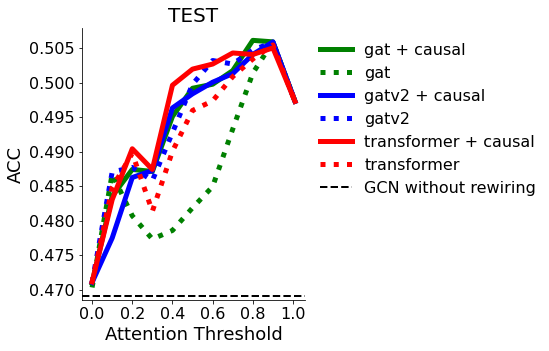

In [6]:
gcn_dim_hidden = 100

for dataset_name in ['chameleon']:
  
  print('=====   {}   ====='.format(dataset_name))
  
  suffix = 'interv.dataloader.ep100.early_stop.ratio'
  task = 'npp'
  eval_metric = 'acc'
  device = 1

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/wikipedia/{}/".format(dataset_name)

  # attn_thresh_list = [0.0,0.05,0.1,0.15,0.2] #,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.01]
  attn_thresh_list = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.01]
  # attn_thresh_list = [0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2]
  # attn_thresh_list = [0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2]
  # attn_thresh_list = [0.0,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05] #,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2]

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
                 'heads': [3],
                 'nl': [1],
                 'hd': [10],
                 'lc': [5.0],
                 'ni': [5]}
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations/rewiring'
  
  base_results_path = os.path.join(results_dir,'{}.{}.base.rewiring.new2.tsv'.format(dataset_name,suffix))
  results_path = os.path.join(results_dir,'{}.{}.attn.rewiring.new2.tsv'.format(dataset_name,suffix))
  if os.path.exists(base_results_path) and os.path.exists(results_path):
    base_results = pd.read_csv(base_results_path,sep='\t')
    all_results = pd.read_csv(results_path,sep='\t')
  else:
    base_results = []
    all_results = []

    for split_no in range(10):
      print(split_no)
      train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000,shuffle_train=False,split_no=split_no)

      for trial_no in range(3):
        base_results_df = evaluate_models_gcn_base(dataset_name,evaluator,save_dir,params_dict,
                            eval_metric=eval_metric,device=device,suffix=suffix + '.{}'.format(split_no),task=task,trial_no=trial_no,
                            gcn_dim_hidden=gcn_dim_hidden,split_no=split_no)
        base_results_df = base_results_df.drop_duplicates(['set','params'])
        base_results_df.index = base_results_df['set'].values
        base_results_df['trial_no'] = trial_no
        base_results.append(base_results_df)

        for attn_thresh in attn_thresh_list:
          results_df = evaluate_models_gcn(dataset_name,evaluator,save_dir,params_dict,
                              eval_metric=eval_metric,device=device,suffix=suffix + '.{}'.format(split_no),
                              task=task,attn_thresh=attn_thresh,trial_no=trial_no,
                              gcn_dim_hidden=gcn_dim_hidden,split_no=split_no)
          results_df['attn'] = attn_thresh
          results_df['trial_no'] = trial_no
          results_df['split_no'] = split_no
          all_results.append(results_df)

    base_results = pd.concat(base_results)
    all_results = pd.concat(all_results)
    base_results.to_csv(base_results_path,sep='\t')
    all_results.to_csv(results_path,sep='\t')
  
  all_results['model'] = [n.split('conv')[0] for n in all_results['model']]
  
  all_results_mean = all_results.groupby(['model','base','params','set','attn']).mean('acc').reset_index()
  base_results_mean = base_results.groupby(['params','set']).mean('acc').reset_index()
  base_results_mean.index = base_results_mean['set'].values

  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,task,'{}.{}.{}.rewire.png'.format(dataset_name,suffix,eval_set))
    plot_attention(all_results_mean,eval_set,eval_metric,save_path=plot_path,base_results_df=base_results_mean)

In [7]:
for model,model_df in all_results_mean[all_results_mean['set'] == 'test'].groupby('model'):
  for base,base_df in model_df.groupby('base'):
      print(model,'\t',base,'\t',model_df['acc'].max())

gat 	 False 	 0.506140350877193
gat 	 True 	 0.506140350877193
gatv2 	 False 	 0.5059210526315789
gatv2 	 True 	 0.5059210526315789
transformer 	 False 	 0.5054824561403508
transformer 	 True 	 0.5054824561403508


=====   chameleon   =====
gat AUC: 0.02618713450292398
gat (base) AUC: 0.01863230994152048
gatv2 AUC: 0.02530628654970761
gatv2 (base) AUC: 0.026555921052631583
transformer AUC: 0.02745467836257312
transformer (base) AUC: 0.024499999999999997


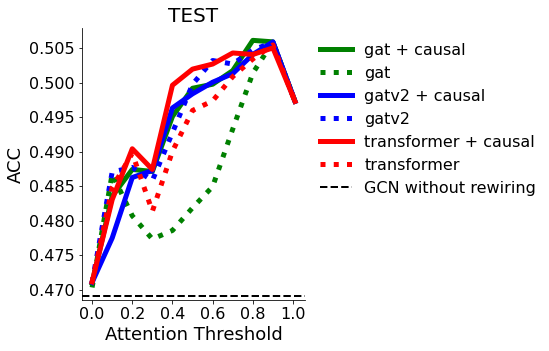

In [7]:
gcn_dim_hidden = 10

for dataset_name in ['chameleon']:
  
  print('=====   {}   ====='.format(dataset_name))
  
  suffix = 'interv.dataloader.ep100.early_stop.ratio'
  task = 'npp'
  eval_metric = 'acc'
  device = 1

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/wikipedia/{}/".format(dataset_name)

  # attn_thresh_list = [0.0,0.05,0.1,0.15,0.2] #,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.01]
  attn_thresh_list = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.01]
  # attn_thresh_list = [0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2]
  # attn_thresh_list = [0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2]
  # attn_thresh_list = [0.0,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05] #,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2]

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
                 'heads': [3],
                 'nl': [2],
                 'hd': [10],
                 'lc': [5.0],
                 'ni': [5]}
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations/rewiring'
  
  base_results_path = os.path.join(results_dir,'{}.{}.base.rewiring.new2.tsv'.format(dataset_name,suffix))
  results_path = os.path.join(results_dir,'{}.{}.attn.rewiring.new2.tsv'.format(dataset_name,suffix))
  if os.path.exists(base_results_path) and os.path.exists(results_path):
    base_results = pd.read_csv(base_results_path,sep='\t')
    all_results = pd.read_csv(results_path,sep='\t')
  else:
    base_results = []
    all_results = []

    for split_no in range(10):
      print(split_no)
      train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000,shuffle_train=False,split_no=split_no)

      for trial_no in range(3):
        base_results_df = evaluate_models_gcn_base(dataset_name,evaluator,save_dir,params_dict,
                            eval_metric=eval_metric,device=device,suffix=suffix + '.{}'.format(split_no),task=task,trial_no=trial_no,
                            gcn_dim_hidden=gcn_dim_hidden,split_no=split_no)
        base_results_df = base_results_df.drop_duplicates(['set','params'])
        base_results_df.index = base_results_df['set'].values
        base_results_df['trial_no'] = trial_no
        base_results_df['split_no'] = split_no
        base_results.append(base_results_df)

        for attn_thresh in attn_thresh_list:
          results_df = evaluate_models_gcn(dataset_name,evaluator,save_dir,params_dict,
                              eval_metric=eval_metric,device=device,suffix=suffix + '.{}'.format(split_no),
                              task=task,attn_thresh=attn_thresh,trial_no=trial_no,
                              gcn_dim_hidden=gcn_dim_hidden,split_no=split_no)
          results_df['attn'] = attn_thresh
          results_df['trial_no'] = trial_no
          results_df['split_no'] = split_no
          all_results.append(results_df)

    base_results = pd.concat(base_results)
    all_results = pd.concat(all_results)
    base_results.to_csv(base_results_path,sep='\t')
    all_results.to_csv(results_path,sep='\t')
  
  all_results['model'] = [n.split('conv')[0] for n in all_results['model']]
  
  all_results_mean = all_results.groupby(['model','base','params','set','attn']).mean('acc').reset_index()
  base_results_mean = base_results.groupby(['params','set']).mean('acc').reset_index()
  base_results_mean.index = base_results_mean['set'].values

  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,task,'{}.{}.{}.rewire.png'.format(dataset_name,suffix,eval_set))
    plot_attention(all_results_mean,eval_set,eval_metric,save_path=plot_path,base_results_df=base_results_mean)

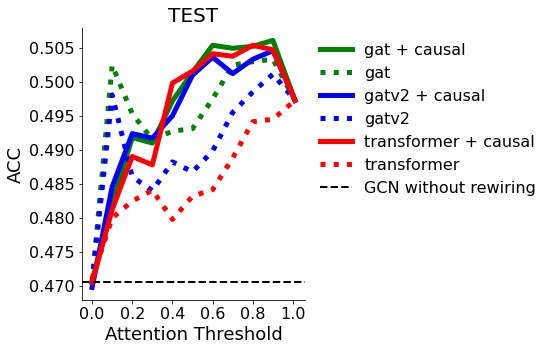

In [17]:
plot_dir = '/home/sandbox/workspace/sequence-graphs/plots'

for eval_set in ['test']:
  plot_path = os.path.join(plot_dir,task,'rewire.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
  plot_attention(all_results_mean,eval_set,eval_metric,save_path=plot_path,base_results_df=base_results_mean)

=====   squirrel   =====
0
1
2
3
4
5
6
7
8
9
gat AUC: 0.02926064681396092
gat (base) AUC: 0.030299711815561937
gatv2 AUC: 0.029556836375280157
gatv2 (base) AUC: 0.03152097342299069
transformer AUC: 0.029313480627601647
transformer (base) AUC: 0.030030419468459798


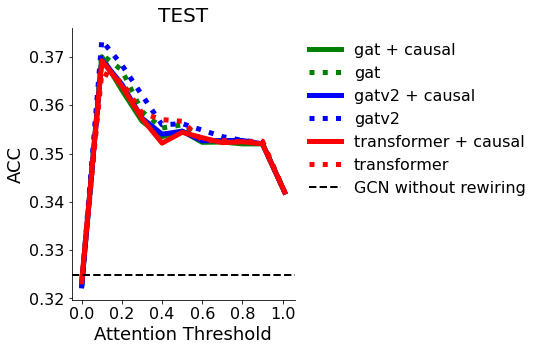

In [8]:
gcn_dim_hidden = 100

for dataset_name in ['squirrel']:
  
  print('=====   {}   ====='.format(dataset_name))
  
  suffix = 'interv.dataloader.ep100.early_stop.ratio'
  task = 'npp'
  eval_metric = 'acc'
  device = 0

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/wikipedia/{}/".format(dataset_name)

  # attn_thresh_list = [0.0,0.05,0.1,0.15,0.2] #,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.01]
  attn_thresh_list = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.01]
  # attn_thresh_list = [0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2]
  # attn_thresh_list = [0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2]
  # attn_thresh_list = [0.0,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05] #,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2]

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
                 'heads': [3],
                 'nl': [1],
                 'hd': [10],
                 'lc': [5.0],
                 'ni': [5]}
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations/rewiring'
  
  base_results_path = os.path.join(results_dir,'{}.{}.base.rewiring.tsv'.format(dataset_name,suffix))
  results_path = os.path.join(results_dir,'{}.{}.attn.rewiring.tsv'.format(dataset_name,suffix))
  if os.path.exists(base_results_path) and os.path.exists(results_path + "K"):
    base_results = pd.read_csv(base_results_path,sep='\t')
    all_results = pd.read_csv(results_path,sep='\t')
  else:
    base_results = []
    all_results = []

    for split_no in range(10):
      print(split_no)
      train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000,shuffle_train=False,split_no=split_no)

      for trial_no in range(3):
        base_results_df = evaluate_models_gcn_base(dataset_name,evaluator,save_dir,params_dict,
                            eval_metric=eval_metric,device=device,suffix=suffix + '.{}'.format(split_no),task=task,trial_no=trial_no,
                            gcn_dim_hidden=gcn_dim_hidden,split_no=split_no)
        base_results_df = base_results_df.drop_duplicates(['set','params'])
        base_results_df.index = base_results_df['set'].values
        base_results_df['split_no'] = split_no
        base_results_df['trial_no'] = trial_no
        base_results.append(base_results_df)

        for attn_thresh in attn_thresh_list:
          results_df = evaluate_models_gcn(dataset_name,evaluator,save_dir,params_dict,
                              eval_metric=eval_metric,device=device,suffix=suffix + '.{}'.format(split_no),
                              task=task,attn_thresh=attn_thresh,trial_no=trial_no,
                              gcn_dim_hidden=gcn_dim_hidden,split_no=split_no)
          results_df['attn'] = attn_thresh
          results_df['trial_no'] = trial_no
          results_df['split_no'] = split_no
          all_results.append(results_df)

    base_results = pd.concat(base_results)
    all_results = pd.concat(all_results)
    base_results.to_csv(base_results_path,sep='\t')
    all_results.to_csv(results_path,sep='\t')
  
  all_results['model'] = [n.split('conv')[0] for n in all_results['model']]
  
  all_results_mean = all_results.groupby(['model','base','params','set','attn','split_no']).mean('acc').reset_index()
  all_results_mean = all_results_mean.groupby(['model','base','params','set','attn']).mean('acc').reset_index()
  
  base_results_mean = base_results.groupby(['params','set','split_no']).mean('acc').reset_index()
  base_results_mean = base_results.groupby(['params','set']).mean('acc').reset_index()
  
  base_results_mean.index = base_results_mean['set'].values

  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,task,'{}.{}.{}.rewire.png'.format(dataset_name,suffix,eval_set))
    plot_attention(all_results_mean,eval_set,eval_metric,save_path=plot_path,base_results_df=base_results_mean)

### ogbn-arxiv

=====   ogbn-arxiv   =====


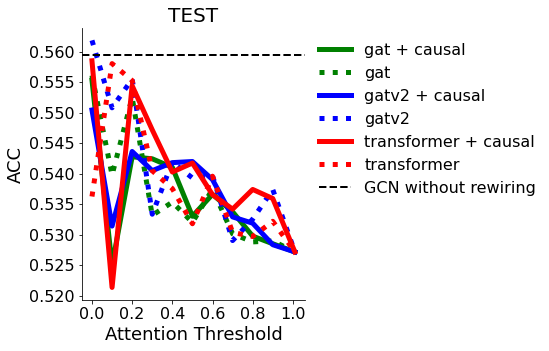

In [10]:
gcn_dim_hidden = 100

for dataset_name in ['ogbn-arxiv']:
  
  print('=====   {}   ====='.format(dataset_name))
  
  suffix = 'interv.dataloader.ep100.early_stop20.ratio'
  task = 'npp'
  eval_metric = 'acc'
  device = 1
  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000,shuffle_train=False)

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
                 'heads': [3],
                 'nl': [1],
                 'hd': [100],
                 'lc': [5.0],
                 'ni': [5]}

  attn_thresh_list = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.01]

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_npp/{}/".format(dataset_name)
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations/rewiring'
  
  base_results_path = os.path.join(results_dir,'{}.{}.base.rewiring.tsv'.format(dataset_name,suffix))
  results_path = os.path.join(results_dir,'{}.{}.attn.rewiring.tsv'.format(dataset_name,suffix))
  if os.path.exists(base_results_path) and os.path.exists(results_path + "K"):
    base_results = pd.read_csv(base_results_path,sep='\t')
    all_results = pd.read_csv(results_path,sep='\t')
  else:
    base_results = []
    all_results = []

    for trial_no in range(1):
      base_results_df = evaluate_models_gcn_base(dataset_name,evaluator,save_dir,params_dict,
                          eval_metric=eval_metric,device=device,suffix=suffix,task=task,trial_no=trial_no,
                          gcn_dim_hidden=gcn_dim_hidden)
      base_results_df = base_results_df.drop_duplicates(['set','params'])
      base_results_df.index = base_results_df['set'].values
      base_results_df['trial_no'] = trial_no
      base_results.append(base_results_df)

      for attn_thresh in attn_thresh_list:
        results_df = evaluate_models_gcn(dataset_name,evaluator,save_dir,params_dict,
                            eval_metric=eval_metric,device=device,suffix=suffix,task=task,attn_thresh=attn_thresh,trial_no=trial_no,
                            gcn_dim_hidden=gcn_dim_hidden)
        results_df['attn'] = attn_thresh
        results_df['trial_no'] = trial_no
        all_results.append(results_df)
      
    base_results = pd.concat(base_results)
    all_results = pd.concat(all_results)

    base_results.to_csv(base_results_path,sep='\t')
    all_results.to_csv(results_path,sep='\t')
  
  all_results['model'] = [n.split('conv')[0] for n in all_results['model']]
  
  all_results_mean = all_results.groupby(['model','base','params','set','attn']).mean('acc').reset_index()
  base_results_mean = base_results.groupby(['params','set']).mean('acc').reset_index()
  base_results_mean.index = base_results_mean['set'].values

  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,task,'{}.{}.{}.rewire.png'.format(dataset_name,suffix,eval_set))
    plot_attention(all_results_mean,eval_set,eval_metric,save_path=plot_path,base_results_df=base_results_mean)

In [ ]:
gcn_dim_hidden = 200

for dataset_name in ['Cora','CiteSeer','PubMed'][0:3]:
  
  print('=====   {}   ====='.format(dataset_name))
  
  suffix = 'interv.dataloader.ep400'
  task = 'npp'
  eval_metric = 'acc'
  device = 1
  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000,shuffle_train=False)

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:1],
                 'heads': [3],
                 'nl': [1],
                 'hd': [200],
                 'lc': [5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/planetoid/{}/".format(dataset_name)

  # attn_thresh_list = [0.0,0.05,0.1,0.15,0.2] #,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.01]
  # attn_thresh_list = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.01]
  attn_thresh_list = [0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2]
  attn_thresh_list = [0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2]

  base_results = []
  all_results = []
  for trial_no in range(5):
    base_results_df = evaluate_models_gcn_base(dataset_name,evaluator,save_dir,params_dict,
                        eval_metric=eval_metric,device=device,suffix=suffix,task=task,trial_no=trial_no,
                        gcn_dim_hidden=gcn_dim_hidden)
    base_results_df = base_results_df.drop_duplicates(['set','params'])
    base_results_df.index = base_results_df['set'].values
    base_results_df['trial_no'] = trial_no
    base_results.append(base_results_df)
    
    results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations/rewiring'
    results_path = os.path.join(results_dir,'{}.{}.rewiring.tsv'.format(dataset_name,suffix))

    # if os.path.exists(results_path):
    #   all_results = pd.read_csv(results_path,sep='\t')
    # else:
    for attn_thresh in attn_thresh_list:
      results_df = evaluate_models_gcn(dataset_name,evaluator,save_dir,params_dict,
                          eval_metric=eval_metric,device=device,suffix=suffix,task=task,attn_thresh=attn_thresh,trial_no=trial_no,
                          gcn_dim_hidden=gcn_dim_hidden)
      results_df['attn'] = attn_thresh
      results_df['trial_no'] = trial_no
      all_results.append(results_df)
      
  base_results = pd.concat(base_results)
  all_results = pd.concat(all_results)
  all_results['model'] = [n.split('conv')[0] for n in all_results['model']]
  
  all_results_mean = all_results.groupby(['model','base','params','set','attn']).mean('acc').reset_index()
  base_results_mean = base_results.groupby(['params','set']).mean('acc').reset_index()
  base_results_mean.index = base_results_mean['set'].values

  for eval_set in ['train','valid','test']:
    # plot_path = os.path.join(plot_dir,task,'{}.{}.{}.rewire.png'.format(dataset_name,suffix,eval_set))
    plot_attention(all_results_mean,
                   eval_set,eval_metric,None,base_results_mean)

    # all_results.to_csv(results_path,sep='\t')

#   plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/'
  
#   for eval_set in ['valid','test']:
#     plot_path = os.path.join(plot_dir,task,'{}.{}.{}.rewire.png'.format(dataset_name,suffix,eval_set))
#     plot_attention(all_results,eval_set,eval_metric,plot_path,base_results_df)

PDP: Data is scrubbed due to cell: 48. Last execution time of this cell at 2022-08-19T19:05:32.343395Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
base_results_df

PDP: Data is scrubbed due to cell: 48. Last execution time of this cell at 2022-08-19T19:05:32.343395Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
gcn_dim_hidden = 50

for dataset_name in ['ogbn-arxiv']:
  
  print('=====   {}   ====='.format(dataset_name))
  
  suffix = 'interv.dataloader.ep50.new'
  task = 'npp'
  eval_metric = 'acc'
  device = 1
  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=50000,shuffle_train=False)

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:1],
                 'heads': [3],
                 'nl': [1],
                 'hd': [200],
                 'lc': [5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_npp/{}/".format(dataset_name)

  # attn_thresh_list = [0.0,0.05,0.1,0.15,0.2] #,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.01]
  attn_thresh_list = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.01]
  # attn_thresh_list = [0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2]

  base_results = []
  all_results = []
  for trial_no in range(1):
    base_results_df = evaluate_models_gcn_base(dataset_name,evaluator,save_dir,params_dict,
                        eval_metric=eval_metric,device=device,suffix=suffix,task=task,trial_no=trial_no,
                        gcn_dim_hidden=gcn_dim_hidden)
    base_results_df = base_results_df.drop_duplicates(['set','params'])
    base_results_df.index = base_results_df['set'].values
    base_results_df['trial_no'] = trial_no
    base_results.append(base_results_df)
    
    results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations/rewiring'
    results_path = os.path.join(results_dir,'{}.{}.rewiring.tsv'.format(dataset_name,suffix))

    # if os.path.exists(results_path):
    #   all_results = pd.read_csv(results_path,sep='\t')
    # else:
    for attn_thresh in attn_thresh_list:
      results_df = evaluate_models_gcn(dataset_name,evaluator,save_dir,params_dict,
                          eval_metric=eval_metric,device=device,suffix=suffix,task=task,attn_thresh=attn_thresh,trial_no=trial_no,
                          gcn_dim_hidden=gcn_dim_hidden)
      results_df['attn'] = attn_thresh
      results_df['trial_no'] = trial_no
      all_results.append(results_df)
      
  base_results = pd.concat(base_results)
  all_results = pd.concat(all_results)
  all_results['model'] = [n.split('conv')[0] for n in all_results['model']]
  
  all_results_mean = all_results.groupby(['model','base','params','set','attn']).mean('acc').reset_index()
  base_results_mean = base_results.groupby(['params','set']).mean('acc').reset_index()
  base_results_mean.index = base_results_mean['set'].values

  for eval_set in ['train','valid','test']:
    # plot_path = os.path.join(plot_dir,task,'{}.{}.{}.rewire.png'.format(dataset_name,suffix,eval_set))
    plot_attention(all_results_mean,
                   eval_set,eval_metric,None,base_results_mean)

    # all_results.to_csv(results_path,sep='\t')

#   plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/'
  
#   for eval_set in ['valid','test']:
#     plot_path = os.path.join(plot_dir,task,'{}.{}.{}.rewire.png'.format(dataset_name,suffix,eval_set))
#     plot_attention(all_results,eval_set,eval_metric,plot_path,base_results_df)

PDP: Data is scrubbed due to cell: 48. Last execution time of this cell at 2022-08-19T19:05:32.343395Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
graph_metric = 'cheeger'

for dataset_name in ['Cora','CiteSeer','PubMed']:
  
  print('=====   {}   ====='.format(dataset_name))
  
  suffix = 'interv.dataloader.ep400'
  task = 'npp'
  eval_metric = 'acc'
  device = "cpu"
  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000)

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
                 'heads': [1,3,5],
                 'nl': [1],
                 'hd': [100,200],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/planetoid/{}/".format(dataset_name)

  attn_thresh_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

  all_results = []
  for attn_thresh in attn_thresh_list:
    print(attn_thresh)
    results_df = evaluate_graph_properties(dataset_name,evaluator,save_dir,params_dict,
                                           graph_metric=graph_metric,device=device,
                                           suffix=suffix,task=task,attn_thresh=attn_thresh)
    results_df['attn'] = attn_thresh
    all_results.append(results_df)

  all_results = pd.concat(all_results)
  all_results['model'] = [n.split('conv')[0] for n in all_results['model']]
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/graph_properties'
  all_results.to_csv(os.path.join(results_dir,'{}.{}.{}.rewire.tsv'.format(dataset_name,suffix,graph_metric)),sep='\t')
#   plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/'
#   plot_path = os.path.join(plot_dir,task,'{}.{}.rewire.png'.format(dataset_name,suffix))
#   plot_attention(all_results,plot_path)

=====   Cora   =====
0.1


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
all_results = pd.concat(all_results)
all_results['model'] = [n.split('conv')[0] for n in all_results['model']]

results_dir = '/home/sandbox/workspace/sequence-graphs/results/graph_properties'
all_results.to_csv(os.path.join(results_dir,'{}.{}.rewire.tsv'.format(dataset_name,suffix)),sep='\t')

In [ ]:
dataset_name = 'cornell'
dataset_dir = os.path.join(ROOT_DIR,'webkb',dataset_name)
data,_ = torch.load(os.path.join(dataset_dir,'processed','data.pt'))
data.y = data.y #.unsqueeze(-1).float()
data.n_id = torch.arange(data.num_nodes)


In [ ]:
attn_thresh_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

In [ ]:
attn_thresh_list[5:]

PDP: Data is scrubbed due to cell: 48. Last execution time of this cell at 2022-08-19T19:05:32.343395Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from scipy.stats import spearmanr

dataset_name = 'CiteSeer'
suffix = 'interv.dataloader'

results_dir = '/home/sandbox/workspace/sequence-graphs/results/graph_properties'
all_results = pd.read_csv(os.path.join(results_dir,'{}.{}.rewire.tsv'.format(dataset_name,suffix)),sep='\t')
  
x_label = 'lc'
graph_metric = 'cheeger'

causal_df = all_results[~all_results['base']]

for eval_set,eval_df in causal_df.groupby('set'):
  plt.figure(figsize=(4,4))
  
  print(spearmanr(eval_df[x_label],eval_df[graph_metric]))
  plt.scatter(eval_df[x_label],eval_df[graph_metric],s=100,alpha=0.5)
  plt.title(eval_set.upper(),fontsize=20)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.xlabel(r'$\lambda^{causal}$',fontsize=18)
  plt.ylabel(graph_metric.upper(),fontsize=18)
  sns.despine()
  plt.show()

PDP: Data is scrubbed due to cell: 48. Last execution time of this cell at 2022-08-19T19:05:32.343395Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
graph_metric = 'connected_components'

for dataset_name in ['Cora']:
  
  print('=====   {}   ====='.format(dataset_name))
  
  suffix = 'interv.dataloader'
  task = 'npp'
  eval_metric = 'acc'
  device = 1
  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000)

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
                 'heads': [1,3,5],
                 'nl': [1],
                 'hd': [100,200],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/planetoid/{}/".format(dataset_name)

  attn_thresh_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

  # base_results_df = evaluate_models_gcn_base(dataset_name,evaluator,save_dir,params_dict,
  #                     eval_metric=eval_metric,device=device,suffix=suffix,task=task)
  # base_results_df.index = base_results_df['set'].values

  all_results = []
  for attn_thresh in attn_thresh_list:
    print(attn_thresh)
    results_df = evaluate_graph_properties(dataset_name,evaluator,save_dir,params_dict,
                                           graph_metric=graph_metric,device=device,
                                           suffix=suffix,task=task,attn_thresh=attn_thresh)
    results_df['attn'] = attn_thresh
    all_results.append(results_df)

  all_results = pd.concat(all_results)
  all_results['model'] = [n.split('conv')[0] for n in all_results['model']]

#   plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/'
#   plot_path = os.path.join(plot_dir,task,'{}.{}.rewire.png'.format(dataset_name,suffix))
#   plot_attention(all_results,plot_path)

PDP: Data is scrubbed due to cell: 48. Last execution time of this cell at 2022-08-19T19:05:32.343395Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from scipy.stats import spearmanr

graph_metric = 'connected_components'

causal_df = all_results[~all_results['base']]
for eval_set,eval_df in causal_df.groupby('set'):
  plt.figure(figsize=(4,4))
  
  print(spearmanr(eval_df['attn'],eval_df[graph_metric]))
  plt.scatter(eval_df['attn'],eval_df[graph_metric],s=100,alpha=0.5)
  plt.title('{}: {}'.format(model,eval_set.upper()),fontsize=20)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.xlabel(r'$\lambda^{causal}$',fontsize=18)
  plt.ylabel(graph_metric.upper(),fontsize=18)
  sns.despine()
  plt.show()

PDP: Data is scrubbed due to cell: 48. Last execution time of this cell at 2022-08-19T19:05:32.343395Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
evaluate_cheeger_constant(dataset,evaluator,save_dir,params_dict,
                    device=0,suffix='interv',task='npp',batch_size=5000,attn_thresh=0.1)